## Goal : check shear SNR prediction vs CLMM mock data

In [2]:
import os
os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.io import ascii
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy import stats, interpolate

import sys
sys.path.append('../../')
import magnification_library as magnification_library
from magnification_library import *

import clmm
import clmm.support.mock_data as mock
import pyccl

from importlib import reload  

In [3]:
clmm.__version__

'1.0.0'

In [4]:
reload(magnification_library)

<module 'magnification_library' from '../../magnification_library.py'>

In [5]:
#define cosmology

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

### Source / lens properties

In [6]:
#Source galaxies properties

#SHEAR LSST
s_e = 0.26
n_e = 26 / u.arcmin**2 # fiducial number after blending + masking https://arxiv.org/pdf/1305.0793.pdf

def shear_pdz(z):
    norm =quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3), 0, np.inf)[0]
    return trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3)/norm   

In [7]:
#Lens properties

cluster_m = 5.e14
cluster_z = 0.3
concentration = 3.
Delta = 200 # mass definition with respect to critical overdensity
cluster_ra = 0.0
cluster_dec = 0.0
zsrc_min=cluster_z+0.1

### CLMM mock data

In [8]:
N_stack = 10

In [9]:
#without shape noise

mock_catalogs_ideal = []

for i in range(N_stack):
    mock_catalogs_ideal.append(mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo_clmm, 'chang13', Delta, massdef='mean', halo_profile_model='nfw', zsrc_min=zsrc_min,
    zsrc_max=3.0, field_size=10, shapenoise=0, photoz_sigma_unscaled=None, ngal_density=n_e.value))

In [10]:
#with shape noise

mock_catalogs = []

for i in range(N_stack):
    mock_catalogs.append(mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo_clmm, 'chang13', Delta, massdef='mean', halo_profile_model='nfw', zsrc_min=zsrc_min,
    zsrc_max=3.0, field_size=10, shapenoise=s_e, photoz_sigma_unscaled=None, ngal_density=n_e.value))

### Check CLMM mock galaxy samples

In [11]:
boxsize = cosmo.arcsec_per_kpc_proper(cluster_z).to(u.deg/u.Mpc)*5

Text(0, 0.5, 'dec - offset [deg]')

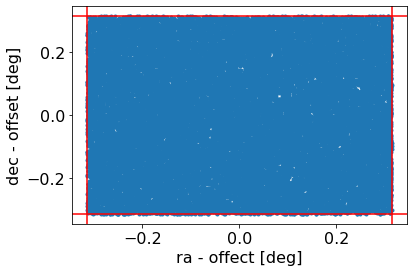

In [12]:
plt.plot(mock_catalogs[i]['ra'], mock_catalogs[i]['dec'],'.')


plt.axvline(boxsize.value,color='red')
plt.axvline(-boxsize.value,color='red')

plt.axhline(boxsize.value,color='red')
plt.axhline(-boxsize.value,color='red')

plt.xlabel('ra - offect [deg]')
plt.ylabel('dec - offset [deg]')

Text(0.5, 0, 'z')

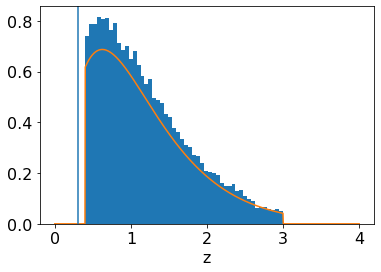

In [13]:
z_s = np.linspace(0.001, 4, 1000)
plt.hist(mock_catalogs[i]['z'], density=True,bins=50);
plt.plot(z_s, trunc_pdf(z_s,1.24, 1.01, 0.51, zsrc_min, 3)/quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3), 0, np.inf)[0], label = 'shear LSST')

plt.axvline(cluster_z)
plt.xlabel('z')

## - Mock data profile construction

In [14]:
cls = []
cls_ideal = []

for i in range(N_stack):
    cls.append(clmm.GalaxyCluster('mock', cluster_ra, cluster_dec, 
                               cluster_z, mock_catalogs[i]))
    cls_ideal.append(clmm.GalaxyCluster('mock', cluster_ra, cluster_dec, 
                               cluster_z, mock_catalogs_ideal[i]))    

In [15]:
test = [clmm.GalaxyCluster('mock', cluster_ra, cluster_dec, 
                               cluster_z, mock_catalogs[i]), clmm.GalaxyCluster('mock', cluster_ra, cluster_dec, 
                               cluster_z, mock_catalogs[i])]

test1 = clmm.GalaxyCluster('mock', cluster_ra, cluster_dec, 
                               cluster_z, mock_catalogs[i])

In [16]:
radial_unit, rmin, rmax, nbins, method = 'Mpc', 0.2, 5, 5, 'evenlog10width'
binedges = clmm.utils.make_bins(rmin, rmax, nbins=nbins, method=method)

In [17]:
mock_profiles = []
mock_profiles_ideal = []

for i in range(N_stack):

    theta, g_t, g_x = cls[i].compute_tangential_and_cross_components(geometry="flat")
    mock_profiles.append(cls[i].make_radial_profile(bin_units="Mpc", bins=binedges, cosmo=cosmo_clmm, include_empty_bins=True, gal_ids_in_bins=True))
    
    theta, g_t, g_x = cls_ideal[i].compute_tangential_and_cross_components(geometry="flat")
    mock_profiles_ideal.append(cls_ideal[i].make_radial_profile(bin_units="Mpc", bins=binedges, cosmo=cosmo_clmm, include_empty_bins=True, gal_ids_in_bins=True))

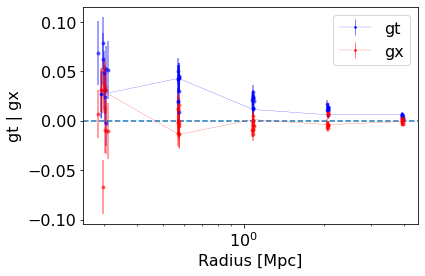

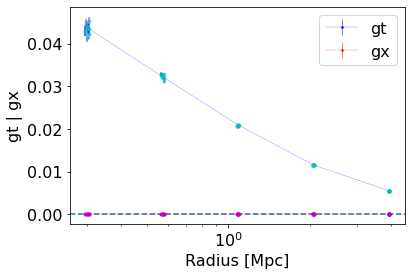

In [18]:
fig, ax = cls[0].plot_profiles() 

[ax.errorbar(cls[i].profile['radius'], cls[i].profile['gt'], yerr = cls[i].profile['gt_err'], alpha=0.5, ecolor='blue',fmt='b.') for i in range(N_stack)];
[ax.errorbar(cls[i].profile['radius'], cls[i].profile['gx'], yerr = cls[i].profile['gx_err'], alpha=0.5, ecolor='red',fmt='r.') for i in range(N_stack)];

ax.set_xscale('log')
ax.axhline(0,linestyle='dashed')
#ax.set_ylim(-0.1,0.25)

#__________________

fig, ax = cls_ideal[0].plot_profiles() 

[ax.errorbar(cls_ideal[i].profile['radius'], cls_ideal[i].profile['gt'], yerr = cls_ideal[i].profile['gt_err'], alpha=0.5, ecolor='blue',fmt='c.') for i in range(N_stack)];
[ax.errorbar(cls_ideal[i].profile['radius'], cls_ideal[i].profile['gx'], yerr = cls_ideal[i].profile['gx_err'], alpha=0.5, ecolor='red',fmt='m.') for i in range(N_stack)];

ax.set_xscale('log')
ax.axhline(0,linestyle='dashed')
#ax.set_ylim(-0.1,0.25)


## - Model construction

In [19]:
dict_profile = {'reduced shear': \
                {'model_func': clmm.theory.compute_reduced_tangential_shear, \
                'noise_func': lambda Ngal: noise_shear(Ngal , s_e),\
                'model_arg': 1., \
                'source_pdz': shear_pdz,\
                'source_density': n_e}}

In [20]:
lens_redshift = cluster_z
profile_type = "reduced shear"

In [21]:
zinf = 1000

bin_center, bin_edges, noise, model = profile_determination(rmin, rmax, radial_unit , lens_redshift, cluster_m , profile_type , dict_profile, cosmo_clmm, nbins, method=method, conc=concentration, delta_mdef=200, zinf=zinf)
bin_center, binedges, Ngal = compute_source_number_per_bin(rmin, rmax, radial_unit, lens_redshift, dict_profile[profile_type]['source_pdz'], dict_profile[profile_type]['source_density'], nbins, method, cosmo_clmm)

## - Profile noise and model construction

In [22]:
#impact of radial distribution

Bs_mean = compute_Bs_mean(cluster_z, zinf, dict_profile[profile_type]['source_pdz'], cosmo_clmm)

noise_radial = np.zeros((len(cls[0].profile['radius']), N_stack))
for i in range(N_stack ):
    for k in range(len(cls[i].profile['radius'])):
        if cls_ideal[i].profile['n_src'][k]>0:
            rgal_list  = cosmo_clmm.rad2mpc(cls_ideal[i].galcat["theta"][cls_ideal[i].profile['gal_id'][k]], cluster_z)
            noise_radial[k,i] = Bs_mean  * np.std(dict_profile[profile_type]['model_func'](rgal_list,cluster_m, concentration,cluster_z, zinf, cosmo_clmm,delta_mdef=200,halo_profile_model='nfw'))

In [23]:
#impact of redshift distribution
noise_zdistrib = np.zeros((len(cls[0].profile['radius']), N_stack))

for i in range(N_stack ):
    for k in range(len(cls[i].profile['radius'])):
        zgal_list  = cls_ideal[i].galcat["z"][cls_ideal[i].profile['gal_id'][k]]
        noise_zdistrib[k,i] = np.std(dict_profile[profile_type]['model_func'](cls_ideal[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, zgal_list, cosmo_clmm,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'))

In [24]:
gt_model3 = np.zeros((len(cls[0].profile['radius']), N_stack))
gt_noise_zdistrib_med = np.zeros((len(cls[0].profile['radius']), N_stack))
gt_noise_zdistrib_upp = np.zeros((len(cls[0].profile['radius']), N_stack))
gt_noise_zdistrib_low = np.zeros((len(cls[0].profile['radius']), N_stack))
gt_noise_zdistrib_std = np.zeros((len(cls[0].profile['radius']), N_stack))

for i in range(N_stack ):
    for k in range(len(cls[i].profile['radius'])):

        gt_model3[k,i] = np.mean( dict_profile[profile_type]['model_func'](cls[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, mock_catalogs[i]['z'], cosmo_clmm,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'))
 
        gt_noise_zdistrib_std[k,i] = np.std( dict_profile[profile_type]['model_func'](cls_ideal[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, mock_catalogs_ideal[i]['z'], cosmo_clmm,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'))
    
        gt_noise_zdistrib_med[k,i] = np.percentile( dict_profile[profile_type]['model_func'](cls_ideal[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, mock_catalogs_ideal[i]['z'], cosmo_clmm,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'), 50)        
               
        gt_noise_zdistrib_low[k,i] = np.percentile( dict_profile[profile_type]['model_func'](cls_ideal[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, mock_catalogs_ideal[i]['z'], cosmo_clmm,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'), 16)
        
        gt_noise_zdistrib_upp[k,i] = np.percentile( dict_profile[profile_type]['model_func'](cls_ideal[i].profile['radius'][k],
                                                  cluster_m, concentration,
                                                  cluster_z, mock_catalogs_ideal[i]['z'], cosmo_clmm,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'), 84)

## - Noise contribution from the profile construction

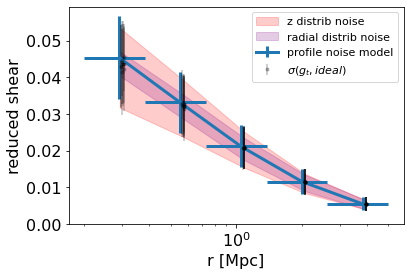

In [25]:

plt.errorbar(bin_center, model, xerr = [bin_center - bin_edges[0:-1], bin_edges[1:] - bin_center],fmt='.-', lw=3,\
             label='profile noise model', yerr = np.sqrt(noise_radial[:,i]**2 + noise_zdistrib[:,i]**2))


i = 0
plt.fill_between(cls[i].profile['radius'], gt_noise_zdistrib_low[:,i], gt_noise_zdistrib_upp[:,i], \
                 color='red', alpha=0.2, label='z distrib noise')
plt.fill_between(cls[i].profile['radius'], gt_model3[:,i] - noise_radial[:,i],gt_model3[:,i] + noise_radial[:,i],\
                 color='purple', alpha=0.2, label='radial distrib noise')


plt.errorbar(mock_profiles_ideal[N_stack-1]['radius'], mock_profiles_ideal[N_stack-1]['gt'],\
              yerr =mock_profiles_ideal[N_stack-1]['gt_err']*np.sqrt(mock_profiles_ideal[N_stack-1]['n_src']), \
              fmt='k.',alpha=0.25, label='$\sigma(g_t,ideal)$')

[plt.errorbar(mock_profiles_ideal[i]['radius'], mock_profiles_ideal[i]['gt'],\
              yerr =mock_profiles_ideal[i]['gt_err']*np.sqrt(mock_profiles_ideal[i]['n_src']), \
              fmt='k.',alpha=0.25) for i in range(N_stack-1)]


plt.ylim(0)
plt.xscale('log')

plt.legend(fontsize='x-small')

plt.ylabel(profile_type)
plt.xlabel('r [' + radial_unit + ']');

### =>The errors on the "ideal" mock data profiles are due to the redshift and radial distribution in each bin

## - Comparison of the measured and forecasted SNR

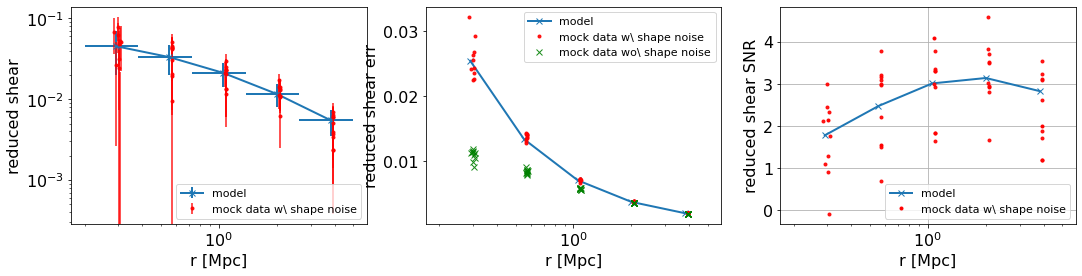

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(18,4), sharex=True, sharey=False)


#profile 
ax1.errorbar(bin_center, model, xerr = [bin_center - bin_edges[0:-1], bin_edges[1:] - bin_center],\
             yerr = noise ,fmt='-x', lw=2, label ='model')
ax1.errorbar(mock_profiles[N_stack-1]['radius'], mock_profiles[N_stack-1]['gt'], \
             yerr =mock_profiles[N_stack-1]['gt_err'], fmt='r.',alpha=0.9, \
             label='mock data w\ shape noise')
[ax1.errorbar(mock_profiles[i]['radius'], mock_profiles[i]['gt'], \
              yerr =mock_profiles[i]['gt_err'], fmt='r.',alpha=0.9) for i in range(N_stack-1)];


#errors
ax2.plot(bin_center, noise, 'x-',lw=2, label ='model')
ax2.plot(mock_profiles[N_stack-1]['radius'], mock_profiles[N_stack-1]['gt_err'], 'r.',\
         label='mock data w\ shape noise',alpha=0.9)
ax2.plot(mock_profiles[N_stack-1]['radius'], mock_profiles_ideal[N_stack-1]['gt_err']*np.sqrt(mock_profiles_ideal[N_stack-1]['n_src']), 'gx',\
         label='mock data wo\ shape noise',alpha=0.9)
[ax2.plot(mock_profiles[i]['radius'], mock_profiles[i]['gt_err'], 'r.',alpha=0.9)\
 for i in range(N_stack-1)];
[ax2.plot(mock_profiles_ideal[i]['radius'],mock_profiles_ideal[i]['gt_err']*np.sqrt(mock_profiles_ideal[i]['n_src']),\
          'gx',alpha=0.9) for i in range(N_stack-1)];


#SNR
ax3.plot(bin_center, model/noise,'x-',lw=2, label ='model')
ax3.plot(mock_profiles[N_stack-1]['radius'], mock_profiles[N_stack-1]['gt']/mock_profiles[N_stack-1]['gt_err'],\
         'r.',label='mock data w\ shape noise')
[ax3.plot(mock_profiles[i]['radius'], mock_profiles[i]['gt']/mock_profiles[i]['gt_err'],'r.',alpha=0.9)\
 for i in range(N_stack-1)];



ax1.legend(fontsize="x-small")
ax2.legend(fontsize="x-small")
ax3.legend(fontsize="x-small")

    
ax1.set_xscale('log')
ax1.set_yscale('log')

ax3.grid()

ax1.set_ylabel(profile_type)
ax1.set_xlabel('r [' + radial_unit + ']');

ax2.set_ylabel(profile_type + " err")
ax2.set_xlabel('r [' + radial_unit + ']');

ax3.set_ylabel(profile_type + " SNR")
ax3.set_xlabel('r [' + radial_unit + ']');


### => Good agreement between CLMM and my code when the signal is dominated by shape noise (and not errors due to the profile construction)